<a href="https://colab.research.google.com/github/michael-0907/tibami/blob/main/bank_after_discussion_0324.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [96]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import precision_recall_curve, average_precision_score

from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, StandardScaler
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
import os


import joblib

In [23]:
data = pd.read_csv("/content/sample_data/bank-full.csv", encoding="utf-8", sep=";")
display(data.shape)
display(data.head(3))

(45211, 17)

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no


In [24]:
df = data.copy()

# 刪除有疑慮的欄位
df = data.drop(columns=["month", "day"])

# 刪除有unknown的行
df = df[~df.isin(["unknown"]).any(axis=1)]

df.shape


(7842, 15)

In [25]:
# 將balance < 0 的刪除
# balance < 0  的刪除後， padys=-1 的就沒了，pdays的最小值變成 1
df = df[df["balance"] >= 0 ]
df.shape


(7371, 15)

In [26]:
for col in df.columns:
  unknown_col = df[col].isin(["unknown"])
  if unknown_col.any():
    print(f"含有unknown的特徵: {col}, 數量: {unknown_col.sum()}")
unknown_row = df.isin(["unknown"]).any(axis=1)
print(f"總行數: {df.shape[0]}")
print(f"含有unknown的行數: {unknown_row.sum()}")


總行數: 7371
含有unknown的行數: 0


In [27]:
column_info = []
for col in df.columns:
  info_dtype = df[col].dtype
  info_isna = df[col].isna().any()
  info_nunique = df[col].nunique()
  info_min = df[col].min()
  info_max = df[col].max()
  info_unique_20 = df[col].unique()[0: 20]

  c = [col, info_dtype, info_isna, info_nunique, info_min, info_max, info_unique_20]
  column_info.append(c)
columns = ["col_name", "dtype", "isna", "unique_num", "min", "max", "unique_20"]
column_info_df = pd.DataFrame(column_info, columns=columns)
display(column_info_df)

# column_info_df.to_csv("column_info_bank.csv")


,col_name,dtype,isna,unique_num,min,max,unique_20
0,age,int64,False,70,18,89,"[33, 36, 44, 26, 51, 30, 34, 49, 47, 40, 38, 5..."
1,job,object,False,11,admin.,unemployed,"[admin., services, management, blue-collar, te..."
2,marital,object,False,3,divorced,single,"[married, single, divorced]"
3,education,object,False,3,primary,tertiary,"[tertiary, secondary, primary]"
4,default,object,False,2,no,yes,"[no, yes]"
5,balance,int64,False,2764,0,81204,"[882, 3444, 2415, 0, 1324, 172, 3132, 1005, 87..."
6,housing,object,False,2,no,yes,"[no, yes]"
7,loan,object,False,2,no,yes,"[no, yes]"
8,contact,object,False,2,cellular,telephone,"[telephone, cellular]"
9,duration,int64,False,957,5,2219,"[39, 144, 73, 140, 119, 21, 449, 175, 86, 81, ..."


In [28]:
# 目標變數編碼

df[col] = df[col].map({"yes": 1, "no": 0})
# display(df["y"].value_counts())


In [29]:
# 二元特徵及目標變數編碼
ordinal_features = ["default", "housing", "loan"]

for col in ordinal_features:
  df[col] = df[col].map({"yes": 1, "no": 0})



In [30]:
# 提取特徵變數及目標變數

X = df.drop(columns=["y"])
y = df["y"]
print(X.shape, y.shape)


(7371, 14) (7371,)


In [31]:
# 切分訓練組及測試組

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True, stratify=y)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)
print(X_train.index.equals(y_train.index))
print(X_test.index.equals(y_test.index))
display(X_train.head(2))
display(X_test.head(2))



(5896, 14) (5896,)
(1475, 14) (1475,)
True
True


,age,job,marital,education,default,balance,housing,loan,contact,duration,campaign,pdays,previous,poutcome
40871,38,admin.,single,secondary,0,245,1,1,cellular,251,2,117,4,failure
44432,34,technician,married,secondary,0,0,1,0,cellular,231,2,2,3,success


,age,job,marital,education,default,balance,housing,loan,contact,duration,campaign,pdays,previous,poutcome
40199,46,technician,married,secondary,0,3434,0,1,cellular,148,2,101,1,success
42783,56,technician,married,tertiary,0,1181,0,0,cellular,186,1,433,1,failure


In [32]:
display(X_train.dtypes.value_counts())

,count
int64,9
object,5


In [47]:
# 欄位分類

int_columns = ['age', 'balance', 'duration', 'campaign', 'pdays', 'previous'] # 數值型欄位，做標準化縮放
ordinal_columns = ["education", "contact"] # 類別型欄位，做標籤編碼
binary_columns = ["default", "housing", "loan"] # 二元欄位，前面已轉換，預處理不再做
ohe_columns = ['job', 'marital', 'poutcome'] # 類別型欄位，做ohe


all_columns = int_columns +  ordinal_columns + binary_columns + ohe_columns
print(len(all_columns))
# all_columns


14


In [53]:
# 設置前處理器

categories_order = [
    ["primary", "secondary", "tertiary"],
    ['cellular', 'telephone']
]

preprocessor = ColumnTransformer(transformers=[
    ("int", StandardScaler(), int_columns),
    ("ordinal", OrdinalEncoder(categories=categories_order), ordinal_columns),
    ("passthrough", "passthrough", binary_columns),
    ("ohe", OneHotEncoder(handle_unknown="ignore", sparse_output=False), ohe_columns)
])



In [130]:
# 整理欄位

ohe_columns = list(preprocessor.named_transformers_["ohe"].get_feature_names_out()) # 取得預處理器中的ohe欄位名稱
all_preprocessed_columns = int_columns +  ordinal_columns + binary_columns + ohe_columns # 整合所有欄位名稱
len(all_preprocessed_columns)


28

In [70]:
# 執行預處理

X_train_preproceed = preprocessor.fit_transform(X_train) # 訓練組預處理
X_test_preproceed = preprocessor.transform(X_test) # 測試組預處

X_train_preproceed = pd.DataFrame(X_train_preproceed, columns=all_preprocessed_columns, index=X_train.index) # 訓練組重新生成dataframe
X_test_preproceed = pd.DataFrame(X_test_preproceed, columns=all_preprocessed_columns, index=X_test.index) # 測試組重新生成dataframe

display(X_train_preproceed.shape, y_train.shape)
display(X_test_preproceed.shape, y_test.shape)

display(X_train_preproceed.head(3))
display(X_test_preproceed.head(3))



(5896, 28)

(5896,)

(1475, 28)

(1475,)

,age,balance,duration,campaign,pdays,previous,education,contact,default,housing,...,job_services,job_student,job_technician,job_unemployed,marital_divorced,marital_married,marital_single,poutcome_failure,poutcome_other,poutcome_success
40871,-0.252423,-0.441068,-0.043211,-0.03153,-0.903468,0.159334,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
44432,-0.601644,-0.515433,-0.127899,-0.03153,-1.929759,-0.042999,1.0,0.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
32760,-0.339728,-0.515433,0.426804,-0.03153,0.863538,0.159334,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0


,age,balance,duration,campaign,pdays,previous,education,contact,default,housing,...,job_services,job_student,job_technician,job_unemployed,marital_divorced,marital_married,marital_single,poutcome_failure,poutcome_other,poutcome_success
40199,0.446017,0.526888,-0.479352,-0.031530,-1.046256,-0.447665,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
42783,1.319067,-0.156965,-0.318445,-0.674794,1.916603,-0.447665,2.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
27167,-0.077813,-0.402520,0.439507,-0.674794,-1.055180,-0.245332,1.0,0.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0


In [94]:
# 訓練模型
# model = RandomForestClassifier(n_estimators=120, max_depth=15, min_samples_leaf=3, class_weight="balanced", random_state=42)

# model = XGBClassifier(
#     objective='binary:logistic',
#     eval_metric='logloss',
#     random_state=42,
#     n_estimators=100,         # 樹的數量
#     max_depth=3,              # 每棵樹最大深度
#     learning_rate=0.2,        # 學習率
#     colsample_bytree=0.8,     # 每棵樹使用特徵比例
#     gamma=0.1,                # 分裂所需的最小損失減少
#     min_child_weight=1,       # 子節點的最小樣本權重
#     scale_pos_weight=2.5,     # 樣本不平衡處理
#     subsample=1,              # 訓練樣本的比例
#     reg_alpha=0.1,            # L1 正則化（注意：是 reg_alpha，不是 alpha）
#     reg_lambda=100            # L2 正則化
# )

# model = LogisticRegression(
#     penalty='l2',              # 使用 L2 正則化（Ridge）
#     C=0.1,                     # 正則化強度，越小越保守（預設為1.0）
#     class_weight='balanced',  # 自動根據樣本數調整權重，處理不平衡資料
#     solver='liblinear',        # 適用於小型資料和 L1/L2 正則化
#     max_iter=1000,             # 最大迭代次數，防止收斂問題
#     random_state=42
# )

# model.fit(X_train_preproceed, y_train)



['test.pkl']

In [121]:
# 定義模型

model_def = {
    "random_forest": {
        "model": RandomForestClassifier(n_estimators=120, max_depth=15, min_samples_leaf=3, class_weight="balanced", random_state=42),
        "cache_path": "/content/rf_model.pkl"
    },
    "xgb": {
        "model": XGBClassifier(objective='binary:logistic', eval_metric='logloss', random_state=42, n_estimators=100,
                    max_depth=3, learning_rate=0.2, colsample_bytree=0.8, gamma=0.1, min_child_weight=1, scale_pos_weight=2.5,
                    subsample=1, reg_alpha=0.1, reg_lambda=100),
        "cache_path": "/content/xgb_model.pkl"
    },
    "logical_reg": {
        "model": LogisticRegression(penalty='l2', C=0.1, class_weight='balanced', solver='liblinear', max_iter=1000, random_state=42),
        "cache_path": "/content/lg_model.pkl"
    }
}




In [122]:
# 訓練模型
for name, data in model_def.items():
  path = data["cache_path"]
  if os.path.exists(path):
    model = joblib.load(path)
  else:
    model = data["model"]
    print(f"模型{name}訓練中")
    model.fit(X_train_preproceed, y_train)
    joblib.dump(model, path)
  data["trained_model"] = model




模型random_forest訓練中
模型xgb訓練中
模型logical_reg訓練中


In [ ]:
# 預測，並取得 y_score
model_results = {}
for name, data in model_def.items():
    model = joblib.load(data["cache_path"])
    print(f"模型{name}預測中")
    y_score = model.predict_proba(X_test_preproceed)[:, 1]
    model_results[name] = {
        "model": model,
        "y_score": y_score
    }

model_results

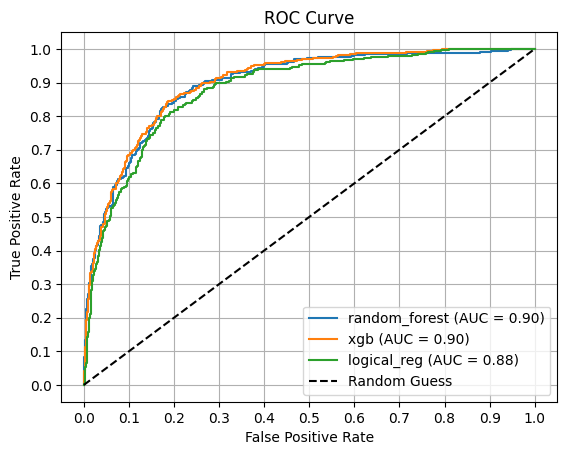

In [128]:
# 畫ROC-AUC

for name, result in model_results.items():
    fpr, tpr, _ = roc_curve(y_test, result["y_score"])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{name} (AUC = {roc_auc:.2f})")

plt.plot([0, 1], [0, 1], 'k--', label="Random Guess")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.xticks(ticks=np.arange(0, 1.1, 0.1))
plt.yticks(ticks=np.arange(0, 1.1, 0.1))
plt.title("ROC Curve")
plt.legend()
plt.grid(True)




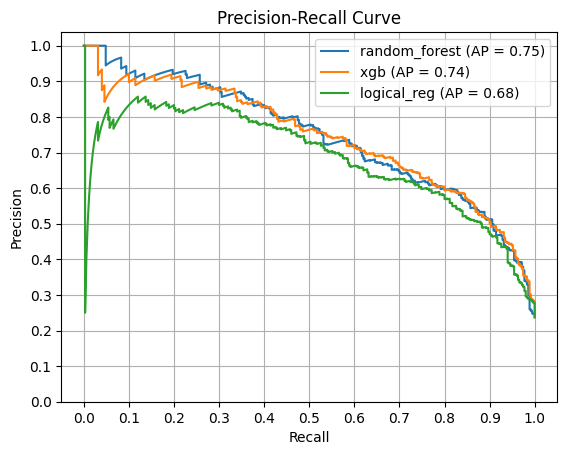

In [129]:
# 畫PR-AUC

for name, result in model_results.items():
    precision, recall, _ = precision_recall_curve(y_test, result["y_score"])
    ap_score = average_precision_score(y_test, result["y_score"])
    plt.plot(recall, precision, label=f"{name} (AP = {ap_score:.2f})")

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.xticks(ticks=np.arange(0, 1.1, 0.1))
plt.yticks(ticks=np.arange(0, 1.1, 0.1))
plt.title("Precision-Recall Curve")
plt.legend()
plt.grid(True)

In [87]:
# 對訓練組預測，並計算accuracy_score, classification_report
y_train_proba = model.predict_proba(X_train_preproceed)[:,1]
threshold = 0.50
y_train_pred = (y_train_proba >= threshold).astype("int")
train_accuracy = accuracy_score(y_train, y_train_pred)
train_report = classification_report(y_train, y_train_pred)
print(f"train accuracy: {train_accuracy}")
print(train_report)

print("-" * 50)

# 對測試組預測，並計算accuracy_score, classification_report
y_test_proba = model.predict_proba(X_test_preproceed)[:, 1]
y_test_pred = (y_test_proba >= threshold).astype("int")
test_accuracy = accuracy_score(y_test, y_test_pred)
test_report = classification_report(y_test, y_test_pred)
print(f"test accuracy: {test_accuracy}")
print(test_report)




train accuracy: 0.8154681139755766
              precision    recall  f1-score   support

           0       0.92      0.83      0.87      4497
           1       0.58      0.77      0.67      1399

    accuracy                           0.82      5896
   macro avg       0.75      0.80      0.77      5896
weighted avg       0.84      0.82      0.82      5896

--------------------------------------------------
test accuracy: 0.816271186440678
              precision    recall  f1-score   support

           0       0.93      0.82      0.87      1125
           1       0.58      0.79      0.67       350

    accuracy                           0.82      1475
   macro avg       0.76      0.81      0.77      1475
weighted avg       0.85      0.82      0.82      1475



In [88]:
# 顯示特徵重要性

feature_importance = model.feature_importances_
sorted_index = np.argsort(feature_importance)[::-1]
sorted_feature = np.array(X_train_preproceed.columns)[sorted_index]
sorted_importance = feature_importance[sorted_index]

important_features = []
threshold = 0.02
for i, j in zip(sorted_feature, sorted_importance):
  if j >= threshold:
    important_features.append(i)
    print(f"{i}: {j}")
print(important_features)



AttributeError: 'LogisticRegression' object has no attribute 'feature_importances_'